### Implementing simple Chatbot Using LangGraph

# LangGraph Streaming Simplified

## 1️⃣ **streaming in LangGraph**, 
which is how the system sends back outputs **while a workflow is running**.  

Instead of waiting for the whole workflow to finish, streaming allows us to see **partial or real-time results**.

### Streaming Methods

- `dot_stream` → synchronous  
- `stream` → asynchronous  

### Key Parameters

- `mode="values"` → Streams the **full state** of the graph after each node.  
- `mode="updates"` → Streams **only the recent updates** to the graph state.

---

## 2️⃣ Understanding `values` vs `updates`

Think of your graph as a **notebook** where you write messages:

| Mode      | What you see in stream                  |
|----------|----------------------------------------|
| updates  | Only the **latest entry** in your notebook. |
| values   | **Everything** in the notebook so far. |

### Example:

Graph nodes: `Node1 → Node2 → Node3`  
State variable: `messages`

- Node1 executes → messages = "Hi"
- Node2 executes → messages = "My name is Chris"
- Node3 executes → messages = "I like cricket"


- `mode="updates"` → Streams:  
"Hi" → "My name is Chris" → "I like cricket"

- `mode="values"` → Streams:  
"Hi" → "Hi, My name is Chris" → "Hi, My name is Chris, I like cricket"


✅ **Summary:**  
- `updates` = partial / recent change  
- `values` = cumulative / full history

---

## 3️⃣ How it works in code

1. **Create a graph** with nodes and edges.  
2. **Define a state object** to store messages.  
3. Use `.dot_stream()` or `.stream()` to get the results.


## 4️⃣ Streaming Events

With the `.stream()` method, you can also get **metadata** about each step of the workflow:

| Field  | Description |
|--------|-------------|
| `event` | Type of action (e.g., chat model starts, node executed) |
| `name`  | Name of the event |
| `data`  | Actual information (messages, tokens, etc.) |

## 5️⃣ Key Takeaways

- `dot_stream()` or `stream()` → Both **stream results** while the workflow executes.  
- `updates` → Streams **only the most recent change**.  
- `values` → Streams the **full graph state** so far.  
- `.stream_events()` → Provides **detailed metadata** for each step, useful for debugging or visualizing events in the graph.


In [39]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [40]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [41]:
import os
from dotenv import load_dotenv
load_dotenv()

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [42]:
# from langchain_openai import ChatOpenAI
# llm=ChatOpenAI(model="gpt-4o")
# llm.invoke("Hello")

In [43]:
from langchain_groq import ChatGroq

llm_groq=ChatGroq(model="llama-3.1-8b-instant")
llm_groq.invoke("Hey I am Nidhi and i like to play cricket")

AIMessage(content="Hello Nidhi, nice to meet you. It's great to hear that you like playing cricket. Cricket is a fantastic sport that requires skill, strategy, and teamwork. Are you more of a batswoman, bowler, or an all-rounder?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 47, 'total_tokens': 101, 'completion_time': 0.077297138, 'prompt_time': 0.002184999, 'queue_time': 0.045209627, 'total_time': 0.079482137}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b1053cc4-891d-461f-9e7d-02e7ca0d3a1e-0', usage_metadata={'input_tokens': 47, 'output_tokens': 54, 'total_tokens': 101})

### We Will start With Creating Nodes

In [44]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

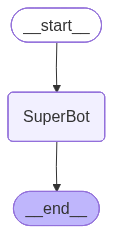

In [45]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [46]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Nidhi And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Nidhi And I like cricket', additional_kwargs={}, response_metadata={}, id='fa9359e2-6dd4-4752-bcea-565a2e54f70a'),
  AIMessage(content='Nice to meet you, Nidhi!  Cricket is a fantastic sport with a massive global following. Which aspect of cricket do you enjoy the most - batting, bowling, fielding, or following a particular team or player?\n\nAre you a fan of international cricket or domestic leagues like the IPL?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 47, 'total_tokens': 108, 'completion_time': 0.115075296, 'prompt_time': 0.00219837, 'queue_time': 0.045481869, 'total_time': 0.117273666}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--af28f645-6612-4a42-8521-498fdb415e9d-0', usage_metadata={'input_tokens': 47, 'output_tokens': 61, 'total_tokens': 108})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.



#### Streaming The Responses With Stream Method

In [47]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Nidhi And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Nidhi. It's great to hear that you like cricket. Cricket is one of the most popular sports in the world, and it has a huge following in many countries. \n\nWhich team or player is your favorite in cricket? Do you like watching the Indian Premier League (IPL), International Cricket Council (ICC) tournaments, or Test cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 47, 'total_tokens': 120, 'completion_time': 0.111632135, 'prompt_time': 0.002508505, 'queue_time': 0.044477531, 'total_time': 0.11414064}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac8fee9d-4130-4df6-9bfe-38cd397f5763-0', usage_metadata={'input_tokens': 47, 'output_tokens': 73, 'total_tokens': 120})]}}


In [48]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Nidhi And I like cricket', additional_kwargs={}, response_metadata={}, id='d7b61e6b-8693-4ca8-b849-5620e4aa360c'), AIMessage(content="Hello Nidhi. It's great to hear that you like cricket. Cricket is one of the most popular sports in the world, and it has a huge following in many countries. \n\nWhich team or player is your favorite in cricket? Do you like watching the Indian Premier League (IPL), International Cricket Council (ICC) tournaments, or Test cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 47, 'total_tokens': 120, 'completion_time': 0.111632135, 'prompt_time': 0.002508505, 'queue_time': 0.044477531, 'total_time': 0.11414064}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac8fee9d-4130-4df6-9bfe-38cd397f5763-0', usage_metadata={'input_tokens': 47, 'output_

In [49]:
for chunk in graph_builder.stream({'messages':"I also like football "},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="It seems like you're a fan of both football and football. I'm assuming you meant that you like football in general, and you didn't mean to say it twice.\n\nIn that case, what is it about football that you enjoy the most? Is it the skill and technique required by the players, the teamwork and strategy involved, or the excitement and unpredictability of the game?\n\nAnd do you have a favorite football position, such as goalkeeper, defender, midfielder, or forward?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 274, 'total_tokens': 372, 'completion_time': 0.157640661, 'prompt_time': 0.015047833, 'queue_time': 0.045366297, 'total_time': 0.172688494}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b0f797a9-2911-47c8-9488-bd6c19a8be04-0', usage_metadata={'input_tokens': 274, 'output_

In [50]:
for chunk in graph_builder.stream({'messages':"I Love sports "},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Nidhi And I like cricket', additional_kwargs={}, response_metadata={}, id='d7b61e6b-8693-4ca8-b849-5620e4aa360c'), AIMessage(content="Hello Nidhi. It's great to hear that you like cricket. Cricket is one of the most popular sports in the world, and it has a huge following in many countries. \n\nWhich team or player is your favorite in cricket? Do you like watching the Indian Premier League (IPL), International Cricket Council (ICC) tournaments, or Test cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 47, 'total_tokens': 120, 'completion_time': 0.111632135, 'prompt_time': 0.002508505, 'queue_time': 0.044477531, 'total_time': 0.11414064}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac8fee9d-4130-4df6-9bfe-38cd397f5763-0', usage_metadata={'input_tokens': 47, 'output_

#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [51]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Nidhi and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Nidhi and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '19dcd722-f436-4e7b-b39b-e935c5283b31', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi,My name is Nidhi And I like cricket', additional_kwargs={}, response_metadata={}, id='d7b61e6b-8693-4ca8-b849-5620e4aa360c'), AIMessage(content="Hello Nidhi. It's great to hear that you like cricket. Cricket is one of the most popular sports in the world, and it has a huge following in many countries. \n\nWhich team or player is your favorite in cricket? Do you like watching the Indian Premier League (IPL), International Cricket Council (ICC) tournaments, or Test cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 47, 'total_tokens': 120, 'completion_time': 0.111632135, 'prompt_time': 0.002508505, 'queue

In [ ]:
y